# Practical session 4 - K-nearest neighbours (K-NN) classification with numpy, scikit-learn, cython and numba

Students (pair):
- [Mathieu CARON]([link](https://github.com/mcaron01/python_sdia))
- [Maxime BACQUET]([link]())

**Useful references for this lab**:

[1] scikit-learn: [documentation](https://scikit-learn.org/stable/modules/neighbors.html?highlight=knn%20classification)

[2] `numba`: [documentation](http://numba.pydata.org/) 

[3] cython: [a very useful tutorial](https://cython.readthedocs.io/en/latest/src/userguide/numpy_tutorial.html#numpy-tutorial), and [another one](http://docs.cython.org/en/latest/src/tutorial/cython_tutorial.html)



## <a name="content">Contents</a>
- [Exercise 1: KNN classification with numpy and sklearn](#ex1)
- [Exercise 2: Code acceleration with cython](#ex2)
- [Exercise 3: Code acceleration with numba](#ex3)
---

In [1]:
%load_ext autoreload
%autoreload 2


## <a name="ex1">Exercise 1: K-Nearest Neighbours (K-NN) classification with numpy and scikit-learn</a> [(&#8593;)](#content)

This session is a first introduction to classification using the most intuitive non parametric method: the $K$-nearest neighbours. The principle is [the following](https://scikit-learn.org/stable/modules/neighbors.html?highlight=knn%20classification). A set of labelled observations is given as a learning set. A classification taks then consists in assigning a label to any new observation. In particular, the K-NN approach consists in assigning to the observation the most frequent label among its $K$ nearest neighbours taken in the training set.

### A. Validation on synthetic data

Load the training and test datasets `data/synth_train.txt` and `data/synth_test.txt`. Targets belong to the set $\{1,2\}$ and entries belong to $\mathbb{R}^2$. The file `data/synth_train.txt` contain 100 training data samples, and `data/synth_test.txt` contains 200 test samples, where:

- the 1st column contains the label of the class the sample;
- columns 2 & 3 contain the coordinates of each sample (in $\mathbb{R}^2$).

Useful commands can be found below.

```python
# load the training set
train = np.loadtxt('data/synth_train.txt')  #...,delimiter=',') if there are ',' as delimiters
class_train = train[:,0]
x_train = train[:,1:]
N_train = train.shape[0]
```

```python
# load the test set
test = np.loadtxt('/datasynth_test.txt') 
class_test_1 = test[test[:,0]==1]
class_test_2 = test[test[:,0]==2]
x_test = test[:,1:]
N_test = test.shape[0]
```

1\. Display the training set and distinguish the two classes. 

> Hint: useful functions include `matplotlib.pyplot.scatter` or `matplotlib.pyplot.plot`.

**Answer:**

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# On charge l'ensemble d'entraînement
train = np.loadtxt('data/synth_train.txt')
class_train = train[:,0]
x_train = train[:,1:]
N_train = train.shape[0]


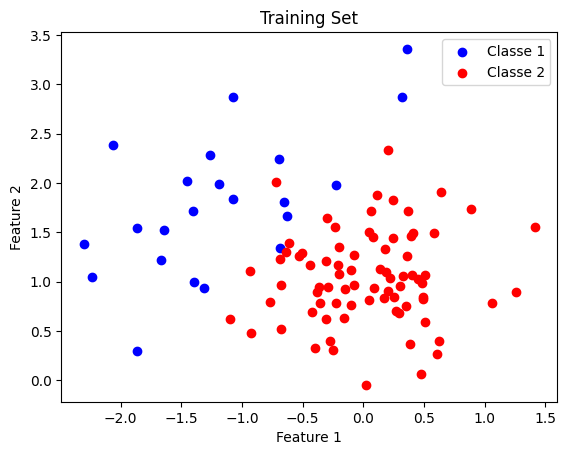

In [3]:
# Affichage de l'ensemble d'entraînement

# On sépare les échantillons par classe
class_1 = x_train[class_train == 1]
class_2 = x_train[class_train == 2]

# On affiche l'ensemble d'entraînement
plt.scatter(class_1[:,0], class_1[:,1], c='blue', label='Classe 1')
plt.scatter(class_2[:,0], class_2[:,1], c='red', label='Classe 2')

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Training Set')
plt.legend()

plt.savefig("img/training_set.png")
plt.show()


2\. Implement the K-nearest neighbours algorithm for classification.

> Hint: 
> - useful functions include `numpy.linalg.norm`, `numpy.argsort`, `numpy.bincount`;
> - implement the algorithm as a function rather than an object. This will drastically simplify the acceleration step using Cython.
> - for an optimized partial sorting procedure, you may have a look at the [`bottleneck.argpartition` function](https://bottleneck.readthedocs.io/en/latest/reference.html#bottleneck.argpartition).

**Answer:**

In [4]:
def k_nearest_neighbors(x_train, class_train, x_test, k):
    """
    Effectue la classification K-NN.

    Args:
    x_train : Les échantillons d'entraînement.
    class_train : Les étiquettes de classe correspondant aux échantillons d'entraînement.
    x_test : Les échantillons de test à classer.
    k : Le nombre de voisins à considérer.

    Returns:
    Les étiquettes de classe prédites pour les échantillons de test.
    """
    # Initialisation d'un tableau pour stocker les étiquettes prédites
    predicted_labels = []

    # On boucle sur nos points à prédire
    for sample in x_test:

        # Calcul des distances entre le point de test et les points d'entraînement
        distances = np.linalg.norm(x_train - sample, axis=1)

        # On cherche les indices des k plus proches voisins
        k_nearest_indices = np.argsort(distances)[:k]
        # Maintenant on prend les étiquettes des classes des k plus proches voisins
        k_nearest_labels = class_train[k_nearest_indices]

        # On compte les occurrences de chaque classe
        counts = np.bincount(k_nearest_labels.astype(int))
        # On trouve la classe majoritaire
        predicted_label = np.argmax(counts)
        # Enfin on ajoute la classe prédite au tableau
        predicted_labels.append(predicted_label)

    return np.array(predicted_labels)


3\. Compute the error rate on the training set and the test set for $K \in \{1,2, \dotsc, 20\}$. Display the classification result (see 1.) for the configuration with the lowest error rate.

**Answer:**

In [5]:
# Load the test set
test = np.loadtxt('data/synth_test.txt')
class_test_1 = test[test[:,0]==1]
class_test_2 = test[test[:,0]==2]
class_test = test[:,0]
x_test = test[:,1:]
N_test = test.shape[0]


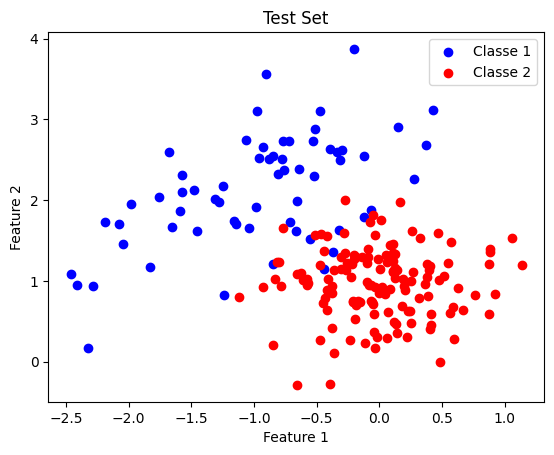

In [6]:
# On affiche le test set pour vérifier que l'import a bien fonctionné et pour avoir une visualisation de notre set de test
plt.scatter(class_test_1[:,1], class_test_1[:,2], c='blue', label='Classe 1')
plt.scatter(class_test_2[:,1], class_test_2[:,2], c='red', label='Classe 2')

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Test Set')
plt.legend()
plt.savefig("img/test_set.png")
plt.show()


Maintenant nous allons calculer le taux d'erreur sur l'ensemble d'entraînement et l'ensemble de test pour K allant de 1 à 20

In [7]:
# Liste pour stocker les taux d'erreur
error_rates_train = []
error_rates_test = []

# Initialisation des variables pour obtenir le meilleur K pour l'ensemble d'entrainement
best_k_train = None
best_error_rate_train = float('inf')
best_predicted_labels_train = None

# Initialisation des variables pour obtenir le meilleur K pour l'ensemble de test
best_k_test = None
best_error_rate_test = float('inf')
best_predicted_labels_test = None

# On boucle pour des valeurs de K allant de 1 à 20
for k in range(1, 21):
    # On effectue la classification K-NN sur l'ensemble d'entraînement avec la fonction d'avant
    predicted_labels_train = k_nearest_neighbors(x_train, class_train, x_train, k)

    # On peut ainsi calculer le taux d'erreur sur l'ensemble d'entraînement
    error_rate_train = np.mean(predicted_labels_train != class_train)
    error_rates_train.append(error_rate_train)

    # On fait la même chose pour l'ensemble de test
    predicted_labels_test = k_nearest_neighbors(x_train, class_train, x_test, k)
    error_rate_test = np.mean(predicted_labels_test != class_test)
    error_rates_test.append(error_rate_test)

    # On met à jour la meilleure configuration si nécessaire pour le train
    if error_rate_train < best_error_rate_train:
        best_k_train = k
        best_error_rate_train = error_rate_train
        best_predicted_labels_train = predicted_labels_train

    # On met à jour la meilleure configuration si nécessaire pour le test
    if error_rate_test < best_error_rate_test:
        best_k_test = k
        best_error_rate_test = error_rate_test
        best_predicted_labels_test = predicted_labels_test

# On peut affichier les listes des taux d'erreur
print("Taux d'erreur sur l'ensemble d'entraînement:", error_rates_train)
print("Taux d'erreur sur l'ensemble de test:", error_rates_test)
print("Le meilleur taux d'erreur sur l'ensemble d'entrainement est", best_error_rate_train, "pour k = ", best_k_train)
print("Le meilleur taux d'erreur sur l'ensemble de test est", best_error_rate_test, "pour k = ", best_k_test)


Taux d'erreur sur l'ensemble d'entraînement: [0.0, 0.03, 0.03, 0.03, 0.05, 0.03, 0.06, 0.06, 0.06, 0.06, 0.07, 0.07, 0.08, 0.07, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08]
Taux d'erreur sur l'ensemble de test: [0.065, 0.06, 0.045, 0.05, 0.06, 0.055, 0.07, 0.07, 0.075, 0.075, 0.09, 0.075, 0.08, 0.075, 0.075, 0.075, 0.08, 0.08, 0.08, 0.08]
Le meilleur taux d'erreur sur l'ensemble d'entrainement est 0.0 pour k =  1
Le meilleur taux d'erreur sur l'ensemble de test est 0.045 pour k =  3


On peut faire un affichage pour avoir une meilleure visualisation

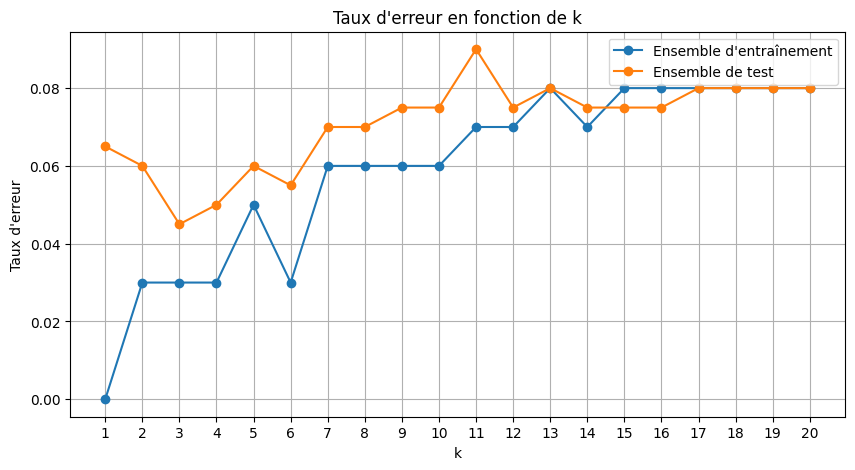

In [8]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, 21), error_rates_train, marker='o', label='Ensemble d\'entraînement')
plt.plot(range(1, 21), error_rates_test, marker='o', label='Ensemble de test')

plt.title('Taux d\'erreur en fonction de k')
plt.xlabel('k')
plt.xticks(np.arange(1, 21, step=1))
plt.ylabel('Taux d\'erreur')
plt.legend()
plt.grid(True)

# On sauvegarde la figure
plt.savefig('img/taux_erreurs_k_1_20.png')

# On affiche le graphique
plt.show()


Ainsi on voit bien visuellement que c'est avec k=3 que notre erreur est minimum sur notre ensemble de test

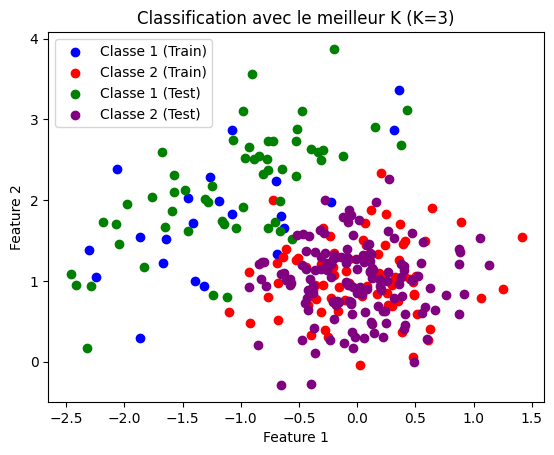

In [9]:
# Affichage du meilleur résultat de classification pour l'ensemble de test
class_1_train = x_train[class_train == 1]
class_2_train = x_train[class_train == 2]

class_1_test = x_test[best_predicted_labels_test == 1]
class_2_test = x_test[best_predicted_labels_test == 2]

plt.scatter(class_1_train[:,0], class_1_train[:,1], c='blue', label='Classe 1 (Train)')
plt.scatter(class_2_train[:,0], class_2_train[:,1], c='red', label='Classe 2 (Train)')

plt.scatter(class_1_test[:,0], class_1_test[:,1], c='green', label='Classe 1 (Test)')
plt.scatter(class_2_test[:,0], class_2_test[:,1], c='purple', label='Classe 2 (Test)')

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Classification avec le meilleur K (K={})'.format(best_k_test))
plt.legend()

plt.savefig("img/classification-avec-k-3.png")

plt.show()


4\. Comment on your results. Which value of $K$ seems optimal ?


**Answer:**

On observe que la valeur optimale pour l'ensemble de test est K = 3. Avec ce K on observe bien sur le graphique que la classification est bien faite entre les classes 1 et 2.

5\. Compare the results of you implementation with those of [`sklearn.neighbors.KNeighborsClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html?highlight=kneighborsclassifier#sklearn.neighbors.KNeighborsClassifier). Compare the runtime of these two versions using the [`timeit`](https://docs.python.org/3/library/timeit.html) module (see session 1).

**Answer:**

In [10]:
from sklearn.neighbors import KNeighborsClassifier
import timeit

# On définit nos valeurs de K
k_values = list(range(1, 21))

# Initialisation des listes pour error rates and execution times
error_rates_custom = []
error_rates_sklearn = []
execution_times_custom = []
execution_times_sklearn = []

for k in k_values:

    # Avec notre implementation de KNN
    start_time = timeit.default_timer()
    predicted_labels_custom = k_nearest_neighbors(x_train, class_train, x_test, k)
    execution_time_custom = timeit.default_timer() - start_time

    error_rate_custom = np.mean(predicted_labels_custom != class_test)
    error_rates_custom.append(error_rate_custom)
    execution_times_custom.append(execution_time_custom)

    # Avec la fonction de sklearn KNeighborsClassifier
    knn_classifier = KNeighborsClassifier(n_neighbors=k)
    start_time = timeit.default_timer()
    knn_classifier.fit(x_train, class_train)
    predicted_labels_sklearn = knn_classifier.predict(x_test)
    execution_time_sklearn = timeit.default_timer() - start_time

    error_rate_sklearn = np.mean(predicted_labels_sklearn != class_test)
    error_rates_sklearn.append(error_rate_sklearn)
    execution_times_sklearn.append(execution_time_sklearn)

# On peut print les error rates
print("Custom implementation error rates:", error_rates_custom)
print("Sklearn implementation error rates:", error_rates_sklearn)

# On peut print les execution times
print("Custom implementation execution times:", execution_times_custom)
print("Sklearn implementation execution times:", execution_times_sklearn)


Custom implementation error rates: [0.065, 0.06, 0.045, 0.05, 0.06, 0.055, 0.07, 0.07, 0.075, 0.075, 0.09, 0.075, 0.08, 0.075, 0.075, 0.075, 0.08, 0.08, 0.08, 0.08]
Sklearn implementation error rates: [0.065, 0.06, 0.045, 0.05, 0.06, 0.055, 0.07, 0.07, 0.075, 0.075, 0.09, 0.075, 0.08, 0.075, 0.075, 0.075, 0.08, 0.08, 0.08, 0.08]
Custom implementation execution times: [0.0038446000035037287, 0.004187400001683272, 0.005645299999741837, 0.003746299997146707, 0.0037349999984144233, 0.0039734999954816885, 0.003767499998502899, 0.004168300001765601, 0.00469850000081351, 0.004068000002007466, 0.0037248000007821247, 0.00381770000240067, 0.005317499999364372, 0.005553199996938929, 0.003756599995540455, 0.005114600004162639, 0.006928400005563162, 0.006463699995947536, 0.005506599998625461, 0.004652800002077129]
Sklearn implementation execution times: [0.010318000000552274, 0.008517400005075615, 0.008626299997558817, 0.010673199998564087, 0.010399899998446926, 0.00945530000171857, 0.0088795999981

Maintenant nous allons les afficher pour avoir une meilleure visualisation de ce qu'il se passe

Tout d'baord, regardons les taux d'erreur :

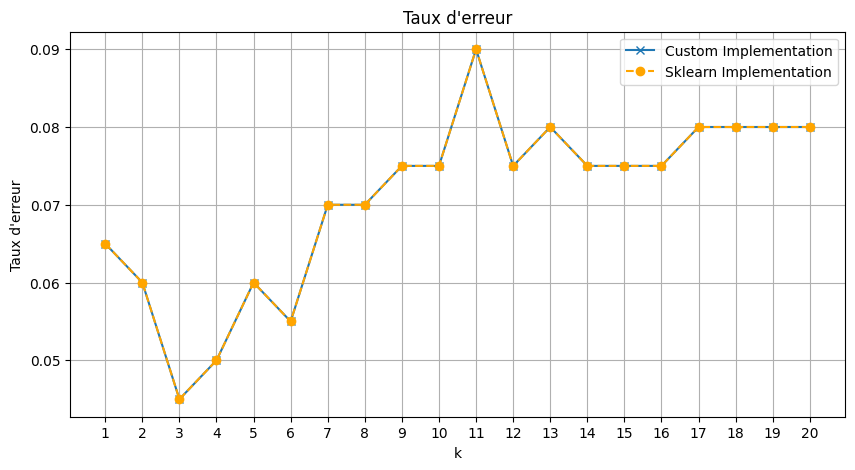

In [11]:
# Création d'une figure pour les taux d'erreur
plt.figure(figsize=(10, 5))

# Notre implementation
plt.plot(k_values, error_rates_custom, marker='x', label="Custom Implementation")
# Sklearn
plt.plot(k_values, error_rates_sklearn, marker='o', linestyle='--', color='orange', label="Sklearn Implementation")

plt.title("Taux d'erreur")
plt.xlabel("k")
plt.xticks(np.arange(1, 21, step=1))
plt.ylabel("Taux d'erreur")
plt.grid(True)
plt.legend()

plt.savefig("img/taux_erreurs_custome_implementation_sklearn.png")

# Affichage
plt.show()


Nous avons donc des résultats similaires sur la prédiction !

Maintenant, regardons le temps d'execution des deux algorithmes :

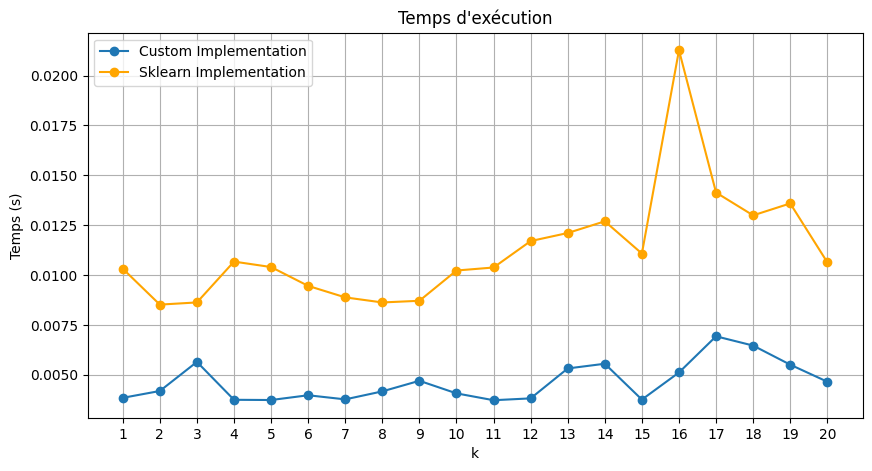

In [12]:
# Création d'une nouvelle figure pour les temps d'exécution
plt.figure(figsize=(10, 5))

# Notre implementation
plt.plot(k_values, execution_times_custom, marker='o', label="Custom Implementation")
# Sklearn
plt.plot(k_values, execution_times_sklearn, marker='o', color='orange', label="Sklearn Implementation")

plt.title("Temps d'exécution")
plt.xlabel("k")
plt.xticks(np.arange(1, 21, step=1))
plt.ylabel("Temps (s)")
plt.grid(True)
plt.legend()

plt.savefig("img/execution_time_custome_implementation_sklearn.png")

# Affichage
plt.show()


On observe donc que le temps d'éxecution pour notre implémentation de KNN est plus court que si on utilise la fonction de sklearn !

### B. Application to a real dataset (Breast cancer Wisconsin).

6\. Apply the K-NN classifier to the real dataset `data/wdbc12.data.txt.` Further details about the data are provided in `data/wdbc12.names.txt`.

> Hint: you can use the function [`train_test_split` from `sklearn.model_selection`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) to split the dataset into a training and a test set.

**Answer:**

In [13]:
# your code


## <a name="ex2">Exercise 2: Code acceleration with cython</a> [(&#8593;)](#content)

Cython allows C code to be easily interfaced with Python. It can be useful to make your code faster for a small coding effort, in particular when using loops. A general approach to optimize your code is outlined in the [Scipy lecture notes, Section 2.4](https://scipy-lectures.org/advanced/optimizing/index.html). Complementary reading about interfacing Python with C can be found in [Section 2.8](https://scipy-lectures.org/advanced/interfacing_with_c/interfacing_with_c.html).

1\. Read carefully the [cython tutorial](http://docs.cython.org/en/latest/src/tutorial/cython_tutorial.html), which describes step by the step how the toy example reported below has been developed.

**Setup**: Compile the toy example provided in `example_cy/` by running, in the command line (anaconda prompt on windows)

```bash
cd example_cy && python setup.py build_ext --inplace
```

Note that the compilation process has been slightly automatised with the instructions reported in `example_cy/setup.py`. To test the module, run

In [14]:
!cd example_cy && python setup.py build_ext --inplace


running build_ext


In [15]:
import example_cy.example_cy.helloworld as toy

toy.printhello()


Hello World


which should display
```python
Hello World
```

> Warning: 
> - do not forget to include an empty `__init__.py` file in the directory where your source code lives (`import` will fail if this is not the case).
> - in case you have any setup issue, take a look at the `notes.md` file.
> - if the C code and/or the executable do not seem to be regenerated by the build instructions, delete the C code and the executable first, and re-execute the compilation afterwards.
> - do not hesitate to restart the Python kernel if necessary when the Cython executable has been re-generated.

2\. Read the [Numpy/Cython tutorial](https://cython.readthedocs.io/en/latest/src/userguide/numpy_tutorial.html#numpy-tutorial), focussing on the paragraphs **Cython at a glance**, and **Your Cython environment** until **"More generic code"**. An example to compile a `.pyx` file depending on `numpy` is included in `example_np_cy/`.

> Remarks: 
> - the `annotate=True` flag in the `setup.py` allows an additional `.html` document to be generated (`<your_module_name>.html`), showing, for each line of the Cython code, the associated C instructions generated. Highlighted in yellow are the interactions with Python: the darker a region appears, the less efficient the generated C code is for this section. Work in priority on these! 
> - make sure all the previously generated files are deleted to allow the .html report to be generated;
> - if you are working on your own machine and don't have a C/C++ compiler installed, read the notes provided in `notes.md`;
> - use `cdef` for pure C functions (not exported to Python), `cpdef` should be favored for functions containing C instructions and later called from Python.

**Answer:**

In [16]:
# your code
!cd example_np_cy && python setup.py build_ext --inplace

running build_ext


In [17]:
import example_np_cy.compute_cy as compute
import numpy as np
array_1 = np.random.uniform(0, 1000, size=(3000, 2000)).astype(np.intc)
array_2 = np.random.uniform(0, 1000, size=(3000, 2000)).astype(np.intc)
a = 4
b = 3
c = 9
compute.compute(array_1, array_2, a, b, c)

array([[1399, 2749,  445, ..., 2326,   85,  484],
       [2479, 2113,  739, ..., 2714,  232, 2260],
       [3022, 1930, 2809, ...,  850, 1600,  922],
       ...,
       [ 159, 2959, 2347, ..., 2452, 1066, 1114],
       [1516, 1768, 2116, ..., 2293, 2479, 2710],
       [2848,  391, 2404, ...,  910, 2728, 2077]], dtype=int32)

3\. Use Cython to implement a faster version of the numpy K-NN classifier implemented in [Exercise 1](#ex1). To do so, apply step-by-step the techniques introduced in the [Numpy/Cython tutorial](https://cython.readthedocs.io/en/latest/src/userguide/numpy_tutorial.html#numpy-tutorial) (*i.e.*, compile and time your code after each step to report the evolution, keeping track of the different versions of the cython function).

> Hint: if you keep numpy arrays, make sure you use memory views (see numpy/cython tutorial) to access the elements within it. Be extremely careful with the type of the input arrays (you may need to recast the format of the input elements before entering the function. The `numpy.asarray` function can prove useful).

> **Detailed guidelines**: a few notes and *caveat* to help you re-writing your code in cython:
> - try to reduce the number of calls to numpy instructions as much as possible;
> - **you do not have to optimize everything**. For the KNN function above, most of the time is spent in computing euclidean distances: you can thus focus on optimizing tihs operations by explicitly writing a for loop, which will ensure a minimal interaction with numpy when generating the associated C code at compilation. Calls to other numpy functions can be kept as-is;
> - if you need to create an array within the cython function, used np.zeros (**do NOT use python lists**), and use a memory view to access its content;
> - specify the type for all variables and numpy arrays. Pay attention to the type of the input arrays passed to the Cython function;
> - whenever an array is returned, use memory views and index(es) to efficiently access its content;
> - some numpy operators (e.g., broadcasting mechanism) do not work with memory views. In this case, you can directly write for loop(s) to encode the operation of interest (the loops will be optimized out at compile time);
> - only use at the final development stage the following cython optimization (not before, as they can crash the program without any help):
>
>```python
>@cython.boundscheck(False)
>@cython.wraparound(False)
>```

**Answer:**

In [18]:
# your code
!cd KNN && python setup.py build_ext --inplace

Compiling KNN.pyx because it changed.
[1/1] Cythonizing KNN.pyx
running build_ext
building 'KNN' extension
creating build
creating build\temp.win-amd64-cpython-311
creating build\temp.win-amd64-cpython-311\Release
"C:\Program Files (x86)\Microsoft Visual Studio\2022\BuildTools\VC\Tools\MSVC\14.37.32822\bin\HostX86\x64\cl.exe" /c /nologo /O2 /W3 /GL /DNDEBUG /MD -IC:\Users\maxim\AppData\Roaming\Python\Python311\site-packages\numpy\core\include -Ic:\Users\maxim\AppData\Local\Programs\Python\Python311\include -Ic:\Users\maxim\AppData\Local\Programs\Python\Python311\Include "-IC:\Program Files (x86)\Microsoft Visual Studio\2022\BuildTools\VC\Tools\MSVC\14.37.32822\include" "-IC:\Program Files (x86)\Microsoft Visual Studio\2022\BuildTools\VC\Auxiliary\VS\include" "-IC:\Program Files (x86)\Windows Kits\10\include\10.0.22621.0\ucrt" "-IC:\Program Files (x86)\Windows Kits\10\\include\10.0.22621.0\\um" "-IC:\Program Files (x86)\Windows Kits\10\\include\10.0.22621.0\\shared" "-IC:\Program Files 

4\. Compare the runtime of the two algorithms (using `timeit.timeit`), and conclude about the interest of using cython in this case.

**Answer:**

(100, 2) (200, 2) (100,)
Custom implementation error rates: [0.065, 0.06, 0.045, 0.05, 0.06, 0.055, 0.07, 0.07, 0.075, 0.075, 0.09, 0.075, 0.08, 0.075, 0.075, 0.075, 0.08, 0.08, 0.08, 0.08]
Cython implementation error rates: [0.065, 0.06, 0.045, 0.05, 0.06, 0.055, 0.07, 0.07, 0.075, 0.075, 0.09, 0.075, 0.08, 0.075, 0.075, 0.075, 0.08, 0.08, 0.08, 0.08]
Custom implementation execution times: [0.006176000002596993, 0.005985000003420282, 0.005616100002953317, 0.00804480000078911, 0.006202599994139746, 0.006150900000648107, 0.005355000001145527, 0.006429499997466337, 0.006312500001513399, 0.0057814999963738956, 0.006207600003108382, 0.005395000000135042, 0.005434700004116166, 0.007333399997150991, 0.005914700006542262, 0.011227799994230736, 0.008877799999027047, 0.007597200004965998, 0.007943899996462278, 0.006862900001578964]
Cython implementation execution times: [0.009649100000387989, 0.0070434000008390285, 0.00684499999624677, 0.009545400003844406, 0.008806100006040651, 0.0084834000008

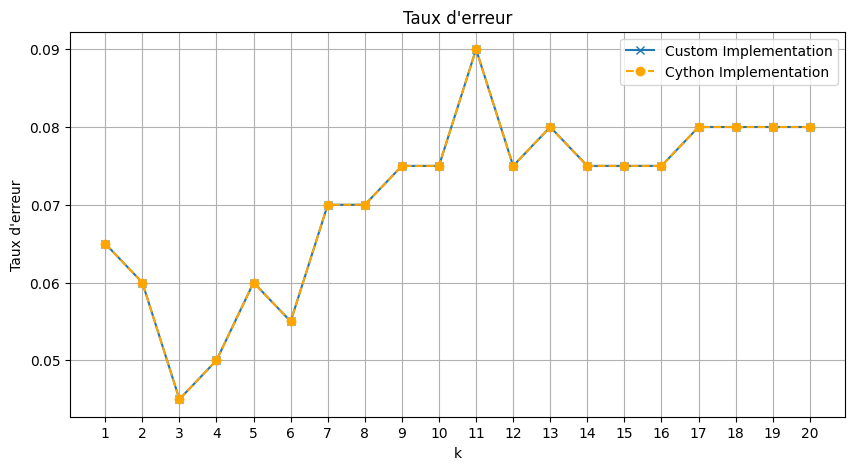

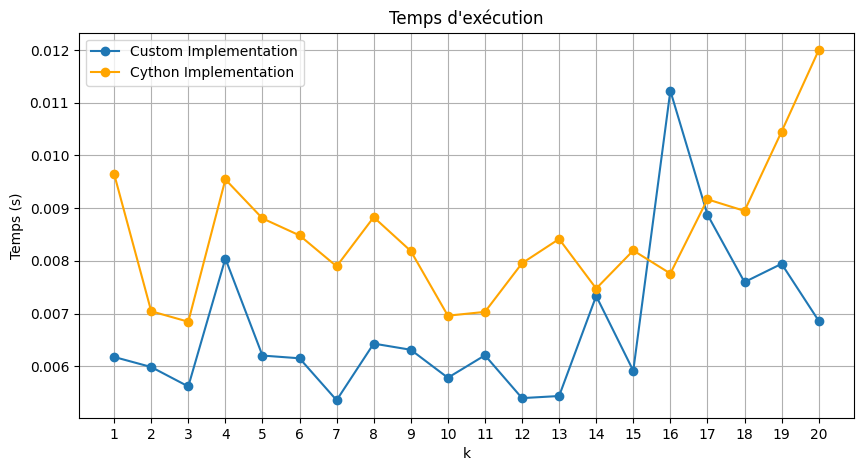

In [22]:
# your code
import KNN.KNN as KNN_cython
import timeit

# On définit nos valeurs de K
k_values = list(range(1, 21))

print(x_train.shape, x_test.shape, class_train.shape)

# Initialisation des listes pour error rates and execution times
error_rates_custom = []
error_rates_cython = []
execution_times_custom = []
execution_times_cython = []

for k in k_values:

    # Avec notre implementation de KNN
    start_time = timeit.default_timer()
    predicted_labels_cython = KNN_cython.k_nearest_neighbors(x_train, class_train, x_test, k)
    execution_time_cython = timeit.default_timer() - start_time

    error_rate_cython = np.mean(predicted_labels_cython != class_test)
    error_rates_cython.append(error_rate_cython)
    execution_times_cython.append(execution_time_cython)

    # Avec notre implementation de KNN
    start_time = timeit.default_timer()
    predicted_labels_custom = k_nearest_neighbors(x_train, class_train, x_test, k)
    execution_time_custom = timeit.default_timer() - start_time

    error_rate_custom = np.mean(predicted_labels_custom != class_test)
    error_rates_custom.append(error_rate_custom)
    execution_times_custom.append(execution_time_custom)

# On peut print les error rates
print("Custom implementation error rates:", error_rates_custom)
print("Cython implementation error rates:", error_rates_cython)

# On peut print les execution times
print("Custom implementation execution times:", execution_times_custom)
print("Cython implementation execution times:", execution_times_cython)

# Création d'une figure pour les taux d'erreur
plt.figure(figsize=(10, 5))

# Notre implementation
plt.plot(k_values, error_rates_custom, marker='x', label="Custom Implementation")
# Cython
plt.plot(k_values, error_rates_cython, marker='o', linestyle='--', color='orange', label="Cython Implementation")

plt.title("Taux d'erreur")
plt.xlabel("k")
plt.xticks(np.arange(1, 21, step=1))
plt.ylabel("Taux d'erreur")
plt.grid(True)
plt.legend()

plt.savefig("img/taux_erreurs_custom_implementation_cython.png")

# Affichage
plt.show()

# Création d'une nouvelle figure pour les temps d'exécution
plt.figure(figsize=(10, 5))

# Notre implementation
plt.plot(k_values, execution_times_custom, marker='o', label="Custom Implementation")
# Cython
plt.plot(k_values, execution_times_cython, marker='o', color='orange', label="Cython Implementation")

plt.title("Temps d'exécution")
plt.xlabel("k")
plt.xticks(np.arange(1, 21, step=1))
plt.ylabel("Temps (s)")
plt.grid(True)
plt.legend()

plt.savefig("img/execution_time_custom_implementation_cython.png")

# Affichage
plt.show()


On peut observer que les résultats obtenus sont identiques, l'implémentation cython a donc bien le même comportement que notre implémentation précédente.

## <a name="ex3">Exercise 3: Code acceleration with numba</a> [(&#8593;)](#content)

`numba` is a just-in-time (JIT) compiler which translates Python codes into efficient machine code at runtime. A significant acceleration can be obtained by adding a few simple decorators to a standard Python function, up to a few restrictions detailed [here](http://numba.pydata.org/numba-doc/latest/user/performance-tips.html).

If you have written most of the KNN classifier of exercise 1 with numpy, there is little to no chance that you will get an acceleration with numba (justifying the use of cython in this case). An interesting acceleration factor can however be obtained for the computation of the total variation investigated in session 2.

1\. Take a look at the [numba 5 min tour](http://numba.pydata.org/numba-doc/latest/user/5minguide.html), and accelerate the total variation code from session 2 with the `@jit` decorator. You may have to rewrite small portions of your code to get the expected acceleration (see [performance tips](http://numba.pydata.org/numba-doc/latest/user/performance-tips.html)).

**Answer:**

In [20]:
# your code
import numpy as np 
#numpy implementation
def gradient2D(X):
    """
    Calcule l'opérateur de gradient discret 2D appliqué à une matrice X.

    Args:
        X (np.ndarray): Matrice d'entrée de forme (M, N).

    Returns:
        tuple: Un tuple contenant deux tableaux représentant le gradient horizontal (X Dh) et le gradient vertical (Dv X) respectivement.

    Raises:
        AssertionError: Si le tableau d'entrée a plus de 2 dimensions.
    """

    # Vérification que le tableau d'entrée a exactement 2 dimensions
    assert X.ndim == 2, "Le tableau d'entrée doit être 2D."
    
    # Calcule les différences horizontales
    Dh = np.diff(X, axis=1)
    Dh = np.concatenate((Dh, np.zeros((X.shape[0], 1))), axis=1)
    
    # Calcule les différences verticales
    Dv = np.diff(X, axis=0)
    Dv = np.concatenate((Dv, np.zeros((1, X.shape[1]))), axis=0)

    return Dh, Dv

def tv(X):
    """
    Calcule la variation totale isotropique discrète (TV) d'une matrice X.

    Args:
        X (np.ndarray): Matrice d'entrée de forme (M, N).

    Returns:
        float: Variation totale de la matrice d'entrée.

    Raises:
        AssertionError: Si le tableau d'entrée a plus de 2 dimensions.
    """
    # Calcul du gradient discret 2D
    Dh, Dv = gradient2D(X)

    # Calcul de la TV
    total_variation = np.sum(np.sqrt(Dh**2 + Dv**2))

    return total_variation

#numba implementation
from numba import jit

@jit(nopython=True)
def tv_numba(X):
    assert X.ndim == 2, "Le tableau d'entrée doit être 2D."
    
    M, N = X.shape
    Dh = np.zeros((M, N))
    Dv = np.zeros((M, N))
    for i in range(M):
        for j in range(N):
            if i < M - 1:
                Dv[i, j] = X[i + 1, j] - X[i, j]
            if j < N - 1:
                Dh[i, j] = X[i, j + 1] - X[i, j]
    total_variation = np.sum(np.sqrt(Dh**2 + Dv**2))
    return total_variation




2\. Compare the runtime of the your numpy implementation and the `numba`-accelerated version (using `timeit.timeit`). 
> **Warning**: first run the numba version once to trigger the compilation, and then time it as usual. This is needed to avoid including the JIT compilation step in the runtime.

**Answer:**

In [21]:
import timeit

X = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
start_time = timeit.default_timer()
tv_it = tv(X)
tv_time = timeit.default_timer() - start_time
tv_numba(X)
start_time = timeit.default_timer()
tv_numba_it = tv_numba(X)
tv_numba_time = timeit.default_timer() - start_time
# Compare runtimes using timeit

print("Numba value:", tv_numba_it)
print("Numpy value:",tv_it)
print("Numba Time:", tv_numba_time)
print("NumPy Time:", tv_time)

Numba value: 20.64911064067352
Numpy value: 20.64911064067352
Numba Time: 5.660000169882551e-05
NumPy Time: 0.00020039999799337238


On peut donc voir qu'en adaptant la fonction total_variation pour ne pas utiliser la fonction diff de numpy (sinon il y a conflit avec une autre fonction diff et numba n'arrive pas à le gérer), on obtient bien le même résultat en utilisant les deux fonctions, avec cependant un temps d'exécution bien plus rapide pour la fonction utilisant numba. Ce module permet donc bien un réel gain en performance.